In [ ]:
from tensorflow.keras.layers import Dense, Activation,Input,Dropout,Flatten,AveragePooling2D
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img,to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf 
import numpy as np
import itertools
import shutil
import random
import os

In [ ]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection.git
%cd /content/Face-Mask-Detection/dataset

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3767, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3767 (delta 0), reused 0 (delta 0), pack-reused 3764
Receiving objects: 100% (3767/3767), 143.05 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (3840/3840), done.
/content/Face-Mask-Detection/dataset


In [ ]:
category = ["with_mask","without_mask"]
data = []
labels = []
for cat in category:
  path = os.path.join(os.getcwd(),cat)
  for image in os.listdir(path):
    image_path = os.path.join(path,image)
    img = load_img(image_path,target_size=(224,224))
    img = img_to_array(img)
    img = preprocess_input(img)

    data.append(img)
    labels.append(cat)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
lb =LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data,dtype="float32")
labels = np.array(labels)

x_train,x_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,
                                                 stratify=labels,random_state=42)

In [ ]:
len(y_train)

3066

In [ ]:
aug = ImageDataGenerator(rotation_range=20,width_shift_range=0.2,
                      height_shift_range =0.2,zoom_range =0.15,horizontal_flip =True
                      ,fill_mode = "nearest")

In [ ]:
base_model = MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
head_mod = base_model.output
head_mod = AveragePooling2D(pool_size=(7,7))(head_mod)
head_mod = Flatten(name = "flatten")(head_mod)
head_mod = Dense(128,activation = "relu")(head_mod)
head_mod = Dropout(0.5)(head_mod)
head_mod = Dense(2,activation = "softmax")(head_mod)
model = Model(inputs =base_model.input,outputs = head_mod)


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(learning_rate =1e-4,weight_decay = 1e-4/20)
model.compile(opt,loss="binary_crossentropy",metrics=["accuracy"])

H = model.fit(aug.flow(x_train,y_train,batch_size = 32),steps_per_epoch=len(x_train) // 32,
              validation_data=(x_test,y_test),validation_steps = len(x_test) // 32,epochs = 20)

[INFO] compiling model...
Epoch 1/20
95/95 [==============================] - 46s 375ms/step - loss: 0.4276 - accuracy: 0.8368 - val_loss: 0.1721 - val_accuracy: 0.9752
Epoch 2/20
95/95 [==============================] - 34s 353ms/step - loss: 0.1554 - accuracy: 0.9614 - val_loss: 0.0940 - val_accuracy: 0.9778
Epoch 3/20
95/95 [==============================] - 34s 353ms/step - loss: 0.1009 - accuracy: 0.9763 - val_loss: 0.0726 - val_accuracy: 0.9831
Epoch 4/20
95/95 [==============================] - 34s 354ms/step - loss: 0.0800 - accuracy: 0.9799 - val_loss: 0.0626 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 34s 359ms/step - loss: 0.0767 - accuracy: 0.9766 - val_loss: 0.0568 - val_accuracy: 0.9831
Epoch 6/20
95/95 [==============================] - 34s 356ms/step - loss: 0.0575 - accuracy: 0.9815 - val_loss: 0.0562 - val_accuracy: 0.9817
Epoch 7/20
95/95 [==============================] - 33s 350ms/step - loss: 0.0541 - accuracy: 0.9838 - val_loss: 0.0

In [ ]:
pred_idx = model.predict(x_test,batch_size = 32)
preds_idx = np.argmax(pred_idx,axis = 1)

24/24 [==============================] - 2s 59ms/step


In [ ]:
print(classification_report(y_test.argmax(axis=1),preds_idx,target_names = lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



Text(0.5, 1.0, 'train loss and accuracy')

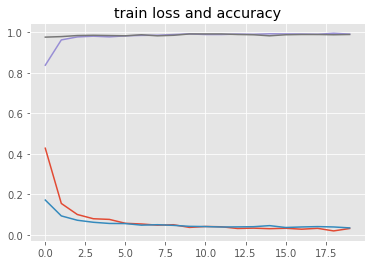

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,20),H.history["loss"],label ="train_loss")
plt.plot(np.arange(0,20),H.history["val_loss"],label ="val_loss")
plt.plot(np.arange(0,20),H.history["accuracy"],label ="train_accuracy")
plt.plot(np.arange(0,20),H.history["val_accuracy"],label ="val_accuracy")
plt.title("train loss and accuracy" )


In [ ]:
model.save("mask_dec",save_format = "h5")